# Import

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mae
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

##  Electricity Consumption Dataset Overview

The dataset contains hourly electricity consumption data collected over multiple years, comprising a total of approximately 54,000+ records.

Each record includes the following fields:

**Timestamp**: The date and time of the observation (with hourly frequency)
**Consumption**: The volume of electricity consumed (in kilowatt-hours or relevant unit) at that timestamp


## Loading the dataset

In [72]:
df = pd.read_csv('./datasets/electricity_consumption_and_production.csv', parse_dates=['DateTime'])
df = df.sort_values('DateTime')
df.set_index('DateTime', inplace=True)
df = df[['Consumption']]   
df.head()

,Consumption
DateTime,
2019-01-01 00:00:00,6352
2019-01-01 01:00:00,6116
2019-01-01 02:00:00,5873
2019-01-01 03:00:00,5682
2019-01-01 04:00:00,5557


In [26]:
print(f"Total missing values of the target variable: {df.isna().sum()}")

Total missing values of the target variable: Consumption    0
dtype: int64


### EDA: Analyze trend, seasonality, cyclicity, residual. Check for stationarity

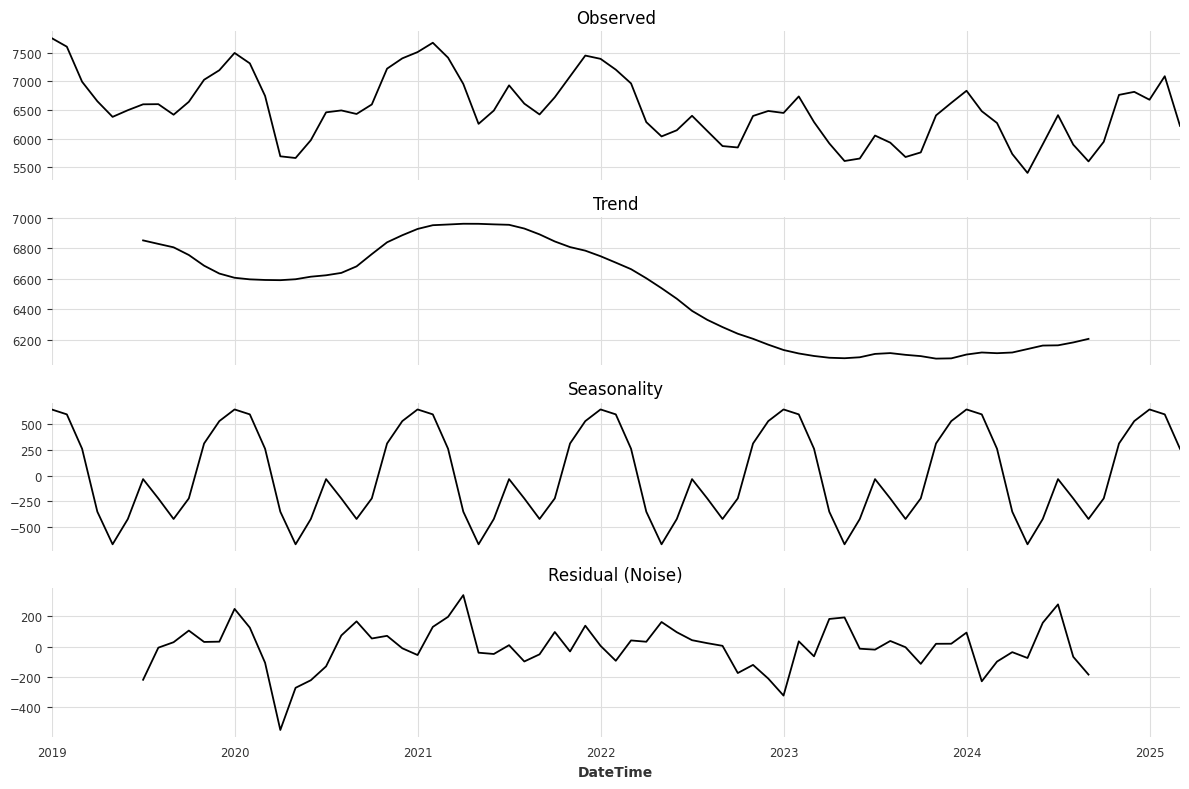

In [34]:
monthly_df = df["Consumption"].resample("ME").mean()

decomposition = seasonal_decompose(monthly_df, model="additive", period=12)

# Візуалізація
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
decomposition.observed.plot(ax=axes[0], title='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Seasonality')
decomposition.resid.plot(ax=axes[3], title='Residual (Noise)')
plt.tight_layout()
plt.show()


### Monthly Decomposition of Electricity Consumption in Romania

This plot shows the additive decomposition of monthly electricity consumption data:

* **Observed**: The original monthly average electricity consumption.
* **Trend**: The long-term pattern, showing a slight downward trend from 2021 to 2023.
* **Seasonality**: Clear yearly seasonal pattern — higher consumption in winter and lower in summer.
* **Residual (Noise)**: Irregular fluctuations not explained by trend or seasonality.


### __Check for stationarity__
In order to ensure a time series is stationary, we can use a statisitcal test, for example, the Dickey-Fuller, which is the most popular one. This test checks for the presence of a unit root, which indicates non-stationarity.

- If __p-value__ < 0.05 → reject __H₀__ → likely stationary
- If __p-value__ ≥ 0.05 → fail to reject __H₀__ → likely non-stationary

In [31]:
def adf_stationarity_test(time_series: pd.Series):
    """Checks if time series is stationary based on ADF test"""

    adf_result = adfuller(time_series)
    p_value = adf_result[1]
    print(f"p_value: {p_value}")

    if p_value < 0.05:
        return True # Reject the null hypothesis: The time series is stationary.
    
    return False # Fail to reject the null hypothesis: The time series is non-stationary.

In [32]:
is_stationary = adf_stationarity_test(monthly_df)
is_stationary

p_value: 0.751580853581589


False

Apply differencing to make the series stationary: $y_t' = y_t - y_{t-1}$

In [33]:
differenced = monthly_df.diff().dropna()
differenced.head(10)

DateTime
2019-02-28   -150.345013
2019-03-31   -612.278696
2019-04-30   -340.301066
2019-05-31   -273.209409
2019-06-30    116.524686
2019-07-31    102.828808
2019-08-31      2.668011
2019-09-30   -184.427375
2019-10-31    225.827364
2019-11-30    384.774024
Freq: ME, Name: Consumption, dtype: float64

In [36]:
monthly_df.describe()

count      75.000000
mean     6528.624254
std       576.235667
min      5400.153631
25%      6093.020161
50%      6482.629032
75%      6941.953271
max      7755.416442
Name: Consumption, dtype: float64

### Build a Predictive Model

In [39]:
def calculate_metrics(test_series: pd.Series, forecast_series: pd.Series):
    """
    Calculate metrics for the forecasted values
    
    Args:
        test_series (pd.Series): Time Series for evaluation
        forecasted_series (pd.Series): Forecasted values

    Returns:
        - mape: Mean Absolute Percentage Error between test vs forecast
        - mae: Mean Absolute Error between test vs forecast 
        - mse: Mean Squared Error between test vs forecast 
    """

    mape = mean_absolute_percentage_error(test_series, forecast_series)
    mae = mean_absolute_error(test_series, forecast_series)
    mse = mean_squared_error(test_series, forecast_series)

    return mape, mae, mse


def visualize_forecast(
    train_series: pd.Series,
    test_series: pd.Series, 
    forecast_series: pd.Series,
    title: str="Forecasting predictions"
):
    """
    Visualize forecasting predictions with metrics
    
    Args:
        train_series (pd.Series): Historircal time series
        test_series (pd.Series): Time Series for evaluation
        forecasted_series (pd.Series): Forecasted values
        title (str): Plot title
    """

    # Calculate metrics
    mape, mae, mse = calculate_metrics(test_series, forecast_series)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot each series
    train_series.plot(ax=ax, label="Train series")
    test_series.plot(ax=ax, label="Test Series")
    forecast_series.plot(ax=ax, label="Predicted Series")
    
    # Plotting titles and labels
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Forecast results")
    ax.grid(True)
    ax.legend(title="Series")

    # Add the metrics as text on the plot
    metrics_text = f"MAPE: {mape:.2f}%\nMAE: {mae:.2f}\nMSE: {mse:.2f}"
    ax.text(0.99, 0.95, metrics_text, transform=ax.transAxes, 
            fontsize=12, verticalalignment='top', horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=1'))

    plt.tight_layout()
    plt.show()

Train-test split

In [40]:
test_size = 12 # use last 12 months as testing data
train_series, test_series = monthly_df[:-test_size], monthly_df[-test_size:]

In [41]:
len(train_series), len(test_series)

(63, 12)

### SARIMA (Seasonal ARIMA)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


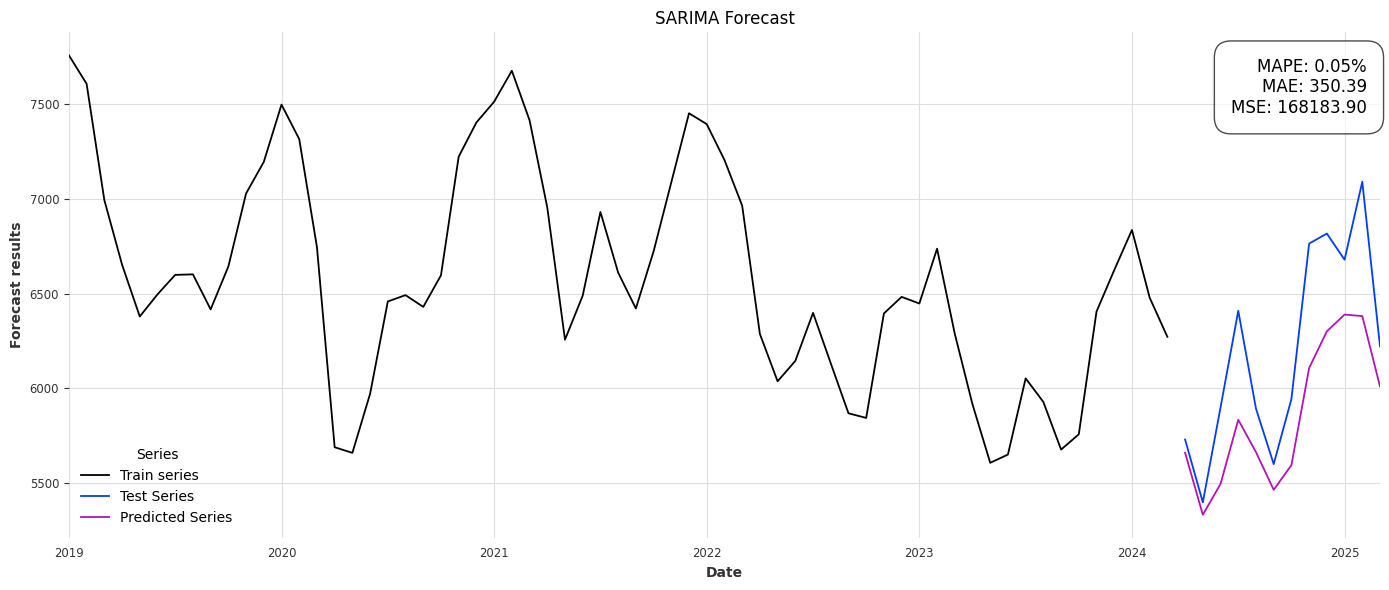

In [62]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train_series, order=(1,1,1), seasonal_order=(1,1,1,12)).fit()
sarima_forecast = sarima_model.forecast(test_size)

visualize_forecast(train_series, test_series, sarima_forecast, title="SARIMA Forecast")

### Prophet

23:39:34 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


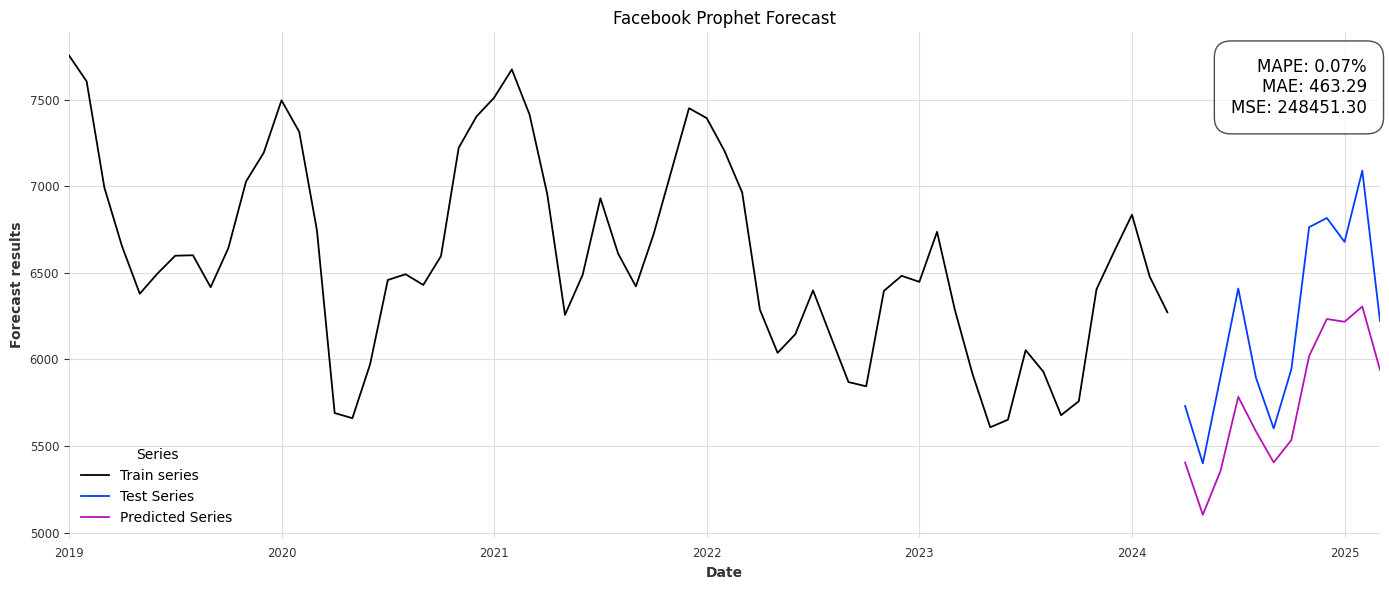

In [ ]:
# Note: Prophet requires train_df in format: {"ds": <timestamps>, "y": <target_variable>}
train_df_prophet = pd.DataFrame({
    'ds': train_series.index, 
    'y': train_series.values 
})

model = Prophet()
model.fit(train_df_prophet)

future = model.make_future_dataframe(periods=test_size, freq='M')
forecast = model.predict(future)
forecast_series = forecast.set_index("ds")["yhaat"].loc[test_series.index]

visualize_forecast(train_series, test_series, forecast_series, title="Facebook Prophet Forecast")

### Time-lagged regression model

In [46]:
def create_lag_features(time_series: pd.Series, lags=12):
    """Create time-lagged features for the provided time series"""

    df = pd.DataFrame(time_series)

    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df.iloc[:, 0].shift(i)
    
    return df

In [ ]:
lags = 12 # Experiment with number of lags to improve model accuracy
time_lagged_df = create_lag_features(monthly_df, lags)
time_lagged_df = time_lagged_df.dropna() # Remove rows with NaN values after applying shifting
time_lagged_df.tail(10)

,Consumption,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
DateTime,,,,,,,,,,,,,
2024-06-30,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356,6835.251344,6623.670699,6405.222222,5758.722148,5678.083333,5929.065860,6053.303763,5651.966667
2024-07-31,6409.166897,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356,6835.251344,6623.670699,6405.222222,5758.722148,5678.083333,5929.065860,6053.303763
2024-08-31,5894.038251,6409.166897,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356,6835.251344,6623.670699,6405.222222,5758.722148,5678.083333,5929.065860
2024-09-30,5601.603399,5894.038251,6409.166897,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356,6835.251344,6623.670699,6405.222222,5758.722148,5678.083333
2024-10-31,5944.462888,5601.603399,5894.038251,6409.166897,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356,6835.251344,6623.670699,6405.222222,5758.722148
2024-11-30,6763.434783,5944.462888,5601.603399,5894.038251,6409.166897,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356,6835.251344,6623.670699,6405.222222
2024-12-31,6816.322581,6763.434783,5944.462888,5601.603399,5894.038251,6409.166897,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356,6835.251344,6623.670699
2025-01-31,6678.596443,6816.322581,6763.434783,5944.462888,5601.603399,5894.038251,6409.166897,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356,6835.251344
2025-02-28,7089.301136,6678.596443,6816.322581,6763.434783,5944.462888,5601.603399,5894.038251,6409.166897,5900.493706,5400.153631,5731.161560,6272.119624,6478.412356


In [48]:
train_df, test_df = time_lagged_df[:-test_size], time_lagged_df[-test_size:]

In [49]:

train_df, test_df = time_lagged_df[:-test_size], time_lagged_df[-test_size:]
X_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]
X_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

In [52]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
y_pred = []
current_input = X_test.iloc[0].values.reshape(1, -1)

for _ in range(len(y_test)):
    prediction = model.predict(current_input)[0]
    y_pred.append(prediction)

    # Slide the window: Remove the oldest lag, add the latest prediction
    current_input = pd.concat([pd.Series([prediction]), pd.Series(current_input[0][:-1])]).values.reshape(1, -1)

In [56]:
forecast_series = pd.Series(y_pred, index=test_series.index)
forecast_series

DateTime
2024-04-30    5957.209473
2024-05-31    5769.245605
2024-06-30    5797.715820
2024-07-31    5962.255859
2024-08-31    5919.853027
2024-09-30    5743.643555
2024-10-31    5740.976562
2024-11-30    6167.371094
2024-12-31    6276.235352
2025-01-31    6050.859375
2025-02-28    5811.634277
2025-03-31    5799.401367
Freq: ME, dtype: float32

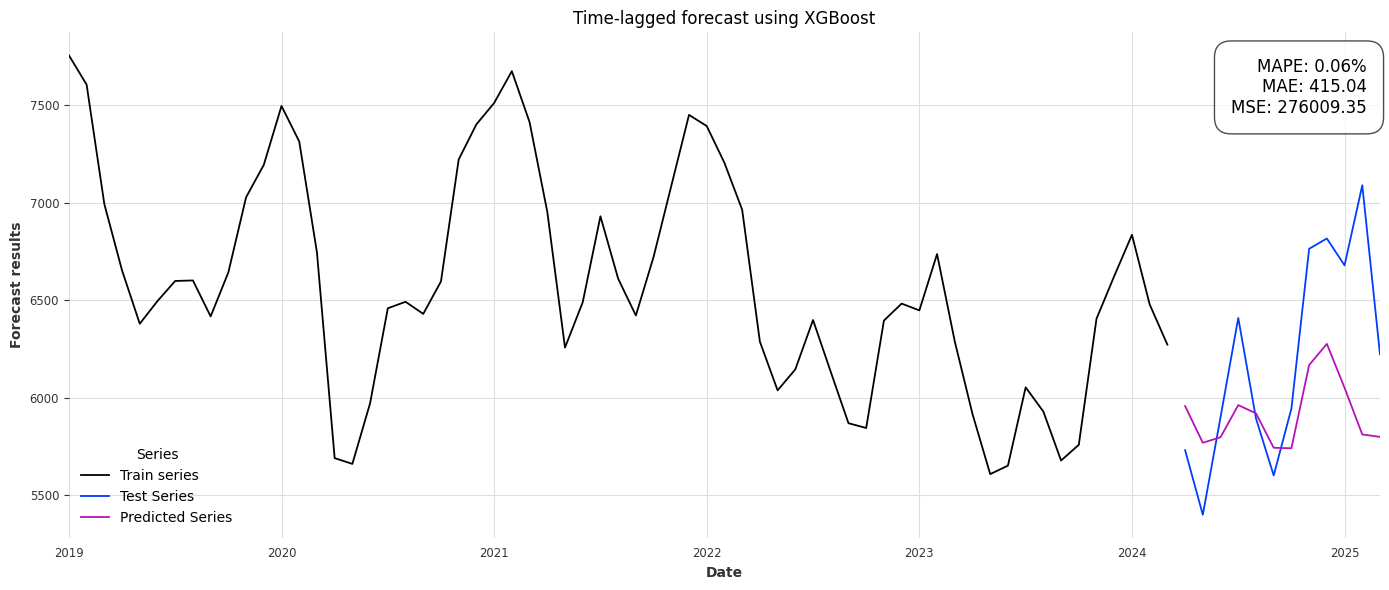

In [57]:
visualize_forecast(
    train_series,
    test_series,
    forecast_series,
    title="Time-lagged forecast using XGBoost"
)

### Summary of Model Performance

| Model                      | MAE (Mean Absolute Error) | MAPE (Mean Absolute % Error) | MSE          | Notes                                                 |
| -------------------------- | ------------------------- | ---------------------------- | ------------ | ----------------------------------------------------- |
| SARIMAX                    | = 350                     | = 0.05%                      | ~168,000     | High accuracy, requires proper seasonal tuning        |
| Time-lagged Regression     | = 415                     | = 0.06%                      | ~276,000     | Simple, fast, but less accurate                       |
| Prophet                    | = 462                     | = 0.07%                      | ~248,000     | Good for seasonal trends                             |
